# The FeatureSpace Intern Recruitment Challenge: Compromise point detection

## I will tackle the problem by progressively answering the following 4 questions:
1. What is the tentative exploitation period of the compromise
2. What is the common point of compromise
3. What is the harvest period of the compromise
4. What are the actual dates of exploitation

5. (validation purpose) Final Analysis and Theory Validation

#### Pre-processing data

In [1]:
'''Import all relative library'''
import pandas as pd
from pandas import DataFrame as df
import numpy as np
import matplotlib
from matplotlib import pyplot as plt

In [2]:
'''Do data preprocessing'''
# read raw data
raw_data = pd.read_csv("input.csv")

# convert date data to formal format
raw_data['date'] = pd.to_datetime(raw_data['date'])  

# convert account and merchant into no.'s
raw_data.loc[:, ['merchant', 'account']] = raw_data.loc[:, ['merchant', 'account']].applymap(lambda x: int(x[1:]))

# Gather names of merchants and accounts
merchants = set(raw_data['merchant']) 
accounts = set(raw_data['account'])

## Q1. Tentative exploitation period
#### Count fraud rate on each day

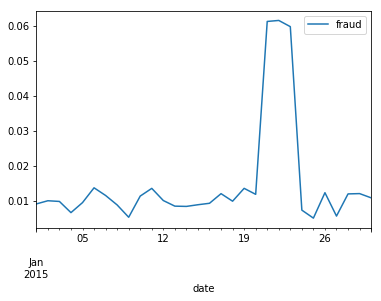

In [3]:
# get overall fraud rate on each day
fraud_col = raw_data.groupby(by='date')['fraud']
fraud_rate_by_date = df(fraud_col.apply(lambda x: (x==True).sum() / float(len(x))))
fraud_rate_by_date.plot()
plt.show()

* Aparantly, we can now locate the exploit point of compromise, which last from __01-21 to 01-23__
* Further analysis would be to analyze the common point of the defrauded accounts and thereby get the point of compromise

## Answer: The *tentative* exploitation period include the period from Jan 21 to Jan 23
#### A quantified method to extract exploitation period

In [4]:
'''Tentative answer for exploitation period of compromise'''
# consider the date that have a fraud rate higher than 150% of the average fraud rate
exp_thresh = fraud_rate_by_date.mean() * 1.5
exp_dates = fraud_rate_by_date[fraud_rate_by_date > exp_thresh].dropna()
exp_dates = [date for date in exp_dates.index]
print('The tentative exploitation dates are: ', exp_dates)

The exploitation dates are:  [Timestamp('2015-01-21 00:00:00'), Timestamp('2015-01-22 00:00:00'), Timestamp('2015-01-23 00:00:00')]


* __It can be hard to ensure that the these dates with abnormally high fraud rate contains all the exploitation dates, some more validation need to be made__

## Q2. Common point of compromise
#### First, get the tentative defruaded accounts based on fraud avtivity during tentative exp period

##### Get the opportunistic probability for an account to commit N fraud on a day, by excluding dates from Jan 21 to 23, and thereby determine how many frauds an account need to commit on a day to ensure (with at least 95% confidence) that this account is not opportunistically defrauded

In [5]:
'''Get all the probablities for an opportunistically defrauded account to commit N fraud on a day'''
# get the opportunistic fraud number for each account on each day (excluding tentative exploitation period)
normal_fraud_data = raw_data.loc[-raw_data.date.isin(exp_dates)].groupby(by=['date', 'account'])['fraud']
normal_fraud_data = normal_fraud_data.sum() 

# caculate the opportunisitic fraud probability for N fraud(s) a day an account
N_fraud_probability = []
for i in range(int(normal_fraud_data.max())+1):
    count = len(normal_fraud_data.loc[normal_fraud_data==i])
    N_fraud_probability.append(count / (30 * len(accounts)))

# caculate the cummulative probablity of N_fraud_probability
# this cum_prob indicate the probablity that an opportunistically defrauded account commit N or less fraud a day
N_fraud_cum_probablility = []
for i in range(1, int(normal_fraud_data.max())+1):
    N_fraud_cum_probablility.append((sum(N_fraud_probability[1:i+1]) / sum(N_fraud_probability[1:])))

In [6]:
'''determine the thresh with 95 percent confidence'''
defraud_account_thresh = 0
cum_prob = 0
for i, prob in enumerate(N_fraud_cum_probablility):
    if prob > 0.95:
        defraud_account_thresh = i+1
        cum_prob = prob
        break
print("During the tentative exploitation period, any account that commit less than or equal to", defraud_account_thresh,\
     "fraud(s) will be excluded, which can theortically exclude", cum_prob, "of the opportunistically defrauded accounts")

During the tentative exploitation period, any account that commit less than or equal to 1 fraud(s) will be excluded, which can theortically exclude 0.9847133757961783 of the opportunistically defrauded accounts


In [7]:
'''Get the tentative defrauded acccounts set'''
# get trasaction data during the exp period
data_during_exp = raw_data.loc[(raw_data.date >= exp_dates[0]) & (raw_data.date <= exp_dates[-1])]

# get all fraudulant transactions during the exp period
defraud_data = data_during_exp[data_during_exp.fraud == True]

# collect defrauded_accounts that at least commit fraud_account_thresh frauds during exploitation
tentative_defrauded_accounts = set()
account_fraud = defraud_data.groupby(by='account')['fraud'].count()
for account in accounts:
    try:
        if account_fraud[account] > defraud_account_thresh:
            tentative_defrauded_accounts.add(account)
    except:
        pass

# count how many defrauded accounts are captured
tentative_defrauded_accounts_no = len(tentative_defrauded_accounts)
print(tentative_defrauded_accounts_no, " tentative defrauded accounts captured")

57  tentative defrauded accounts captured


#### Analyze the activity of tentative defrauded accounts

most relative merchant is:  18  which correlates with:  1.0  defrauded accounts


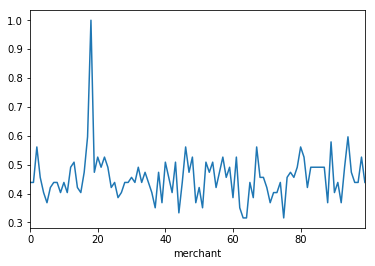

In [8]:
'''Analyze the correlation between the defrauded accounts and each merchant'''
# get a list of merchants that each account has had transaction(s) before
# get transactions before date of exploitation, and only of defrauded accounts
data_before_exp = raw_data.loc[(raw_data.date < exp_dates[0]) & raw_data.account.isin(tentative_defrauded_accounts)]

# get no of defrauded accounts each merchant has had transactions with
account_merchant = data_before_exp.groupby(by='merchant')['account'].apply(lambda x: len(set(x)) / tentative_defrauded_accounts_no)

# display result
print("most relative merchant is: ", account_merchant.argmax(), " which correlates with: ", \
      account_merchant.max(), " defrauded accounts")
account_merchant.plot()
plt.show()

### Simple analysis
* The analysis show that, for those __highly confident defrauded accounts__ (which committed at least 2 fraud during the exploit period) all had their information stored in __M18__, while comparitively, for most of the other merchants, only around half of these defrauded accounts have had transaction with them respectively.
* It can be concluded with high confidence that __M18 is the common point of compromise__, from the aforementioned extreme correlation

## Answer: M18 is the common point of compromise
#### A quantified method to get the compromised merchant

In [28]:
'''Answer for common point of compromise'''
compromised_merchant = account_merchant.argmax()
print("The compromised merchant is: M", compromised_merchant)

The compromised merchant is: M 18


## Q3. What is the Harvest period
#### analysis of the transaction activity between tentative defrauded accounts and compromised merchant

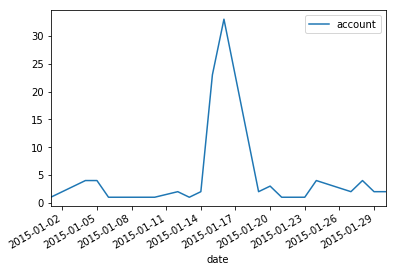

In [10]:
'''Analyze transaction activity of tentative defrauded accounts with compromised merchant'''
# get tentative defrauded accounts' activity with compromise merchant
# get only data related to defrauded accounts
tentative_defrauded_accounts_data = raw_data[raw_data.account.isin(tentative_defrauded_accounts) & \
                                   (raw_data.merchant == compromised_merchant)]
# count transactions of tentative defrauded accounts with each merchants on each day
tentative_defrauded_accounts_data = tentative_defrauded_accounts_data.loc[:, ['date', 'account']]
transaction_no_data = tentative_defrauded_accounts_data.groupby(by='date')
transaction_no_data = transaction_no_data.count()

# display data
transaction_no_data.plot()
plt.show()

### Simple analysis
* The defrauded accounts all had __unusually large number of transactions__ with the compromised merchant between __Jan 15 and Jan 16__, which according to theory, represents the harvest period

## Answer: The harvest lasted from Jan 15 to Jan 16
#### a quantified method to get the harvest period

In [11]:
'''Answer for harvest period of compromise'''
# consider dates when tentative defrauded accounts had abnormally large volumn of transactions with compromised merchant
harvest_thresh = transaction_no_data.mean() * 1.5
harvest_dates = transaction_no_data[transaction_no_data > harvest_thresh].dropna()
harvest_dates = [date for date in harvest_dates.index]
print('The harvest periods include dates: ', harvest_dates)

The harvest periods include dates:  [Timestamp('2015-01-15 00:00:00'), Timestamp('2015-01-16 00:00:00')]


## Q4. What are the actual dates of exploitation
#### get the actual defrauded accounts based on the harvest period transaction data

In [18]:
'''Get the actual defrauded accounts'''
# assuming all accounts that transacted on the common point of compromise during the harvest period are defrauded
defrauded_accounts = set(raw_data.loc[(raw_data.merchant==compromised_merchant) & raw_data.date.isin(harvest_dates)]['account'])
defrauded_accounts_no = len(defrauded_accounts)
print(defrauded_accounts_no, " defrauded accounts are captured")

53  defrauded accounts are captured


In [24]:
'''Analyze fraudulant transaction activity of defrauded accounts'''
# get defrauded accounts' fraudulant transaction no on each day
# get only fraud related to defrauded accounts
defrauded_accounts_data = raw_data[raw_data.account.isin(defrauded_accounts) & raw_data.fraud]
# count fruadulant transactions of defrauded accounts with each merchants on each day
defrauded_accounts_data = defrauded_accounts_data.loc[:, ['date', 'merchant']]
fraud_no_data = defrauded_accounts_data.groupby(by='date')
fraud_no_data = fraud_no_data.count()

## Answer: Dates of Compromise are: Jan 15, 16, 21, 22, 23

#### Recaculate the exploitation period based on a more confident defrauded account set

In [27]:
'''Final answer for exploitation period of compromise'''
# consider the date that have a fraud activity higher than 150% of the average fraud rate
exp_thresh = fraud_no_data.mean() * 1.5
exp_dates = fraud_no_data[fraud_no_data > exp_thresh].dropna()
exp_dates = [date for date in exp_dates.index]
print('The exploitation dates are: ', exp_dates)

The exploitation dates are:  [Timestamp('2015-01-21 00:00:00', freq='D'), Timestamp('2015-01-22 00:00:00', freq='D'), Timestamp('2015-01-23 00:00:00', freq='D')]


## P5. Final overall analysis and theory validation
#### Analyze the overall behavior of defrauded accounts in two respects:
1. The activity with compromised merchant
2. The fraud commited each day over the month

In [23]:
'''Re-Analyze Analyze behavior of defrauded accounts with compromised merchant'''
# get defrauded accounts' activity with compromise merchant
# get only data related to defrauded accounts
defrauded_accounts_data = raw_data[raw_data.account.isin(defrauded_accounts) & \
                                   (raw_data.merchant == compromised_merchant)]
# count transactions of tentative defrauded accounts with each merchants on each day
defrauded_accounts_data = defrauded_accounts_data.loc[:, ['date', 'account']]
transaction_no_data = defrauded_accounts_data.groupby(by='date')
transaction_no_data = transaction_no_data.count()

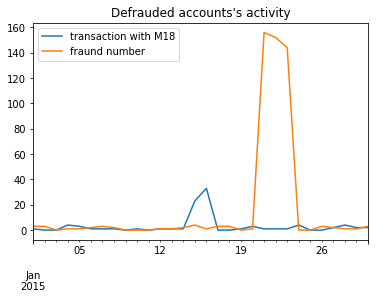

In [25]:
'''Data visualization'''
# combine both data and draw them out
# first, reindex each data so that their shapes match each other
new_index = pd.date_range('2015-01-01', periods=30)
transaction_no_data = transaction_no_data.reindex(new_index, fill_value=0)
fraud_no_data = fraud_no_data.reindex(new_index, fill_value=0)
# do the concatenation
defrauded_account_activity = pd.concat([transaction_no_data, fraud_no_data], axis=1)
defrauded_account_activity = defrauded_account_activity.rename(columns={'merchant': 'fraund number', 'account': 'transaction with M18'})
# display the graph
defrauded_account_activity.plot(title='Defrauded accounts\'s activity')
plt.show()

### Simple comments:
* The graph above proves that the exploitation dates are Jan 21, 22, 23
* The graph above matches perfectly with theory (according to the document of the problem)
* The match, on the other hand, validated our previous data analysis

# Conclusion
1. The compormised merchant is __M18__
2. The harvest period is Jan 15, 16
3. The exploitation period is Jan 21, 22, 23